# Bayesian Statistical Modeling using PyStan
## The Basics
In many machine learning modeling techniques, the goal is to find model parameters which produce the least error in predicting outcomes given a particular set of data on which the model can be trained. In Bayesian modeling, the underlying philosophy changes slightly, and the goal becomes to find model parameters which are most likely to explain the observed data. The reason "Bayesian" is attached to this underlying thought is that one can ask the mathematical question "Given the data, which parameters are most likely to explain the outcome?" This translates directly to a conditional probability $P(\theta| X)$ where $\theta$ are the model parameters and $X$ is the given data. Using Bayes' theorem, this probability becomes:
$$
P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)},
$$
or more succinctly, 
$$
P(\theta|X) \propto P(X|\theta)P(\theta).
$$
The distribution $P(\theta)$ is called a _prior_ distribution (since this is an assumption made about the model parameters independent of the data), and the conditional distribution $P(\theta|X)$ is called a _posterior_ distribution. The goal in Bayesian modelling is to accurately describe the posterior distribution. There are a number of techniques for doing this. In Bayesian variational inference, the posterior is assumed to come from a parameterized family of distributions. For example, one can assume that the posterior is some multivariate normal distribution with a location vector and positive definite matricial scale. Then these parameters can be optimized against the data to find the distribution from that parameterized family which is most likely to explain the data. Bayesian variational inference has the advantage that it can be turned into a numerical optimization problem, which are a very well-studied area of computational mathematics, and thus there are a wide number of available techniques and software packages which can be leveraged. Bayesian variational inference scales quite well if we are dealing with a very large data set. On the other hand, it is entirely possible that a posterior distribution is not well-approximated by the parameterized family the data scientist had in mind. Worse yet, maybe the posterior distribution is hard to estimate by any parameterized family of probability distributions! 

Thankfully, there is an alternative in Markov Chain-Monte Carlo (MCMC) methods. For a striking (but mathematically elaborate) introduction to these methods, see [this survey](https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/S0273-0979-08-01238-X.pdf). For some, MCMCs might elicit thoughts of Gibbs sampling, which was one of the first computationally tractable MCMC methods and is quite successful for certain problems. However, Gibbs sampling suffers from some well-known drawbacks such slow convergence and restrictive choice of priors (based on conjugacy). The method we are using here is based on the Hamiltonian Monte Carlo method, which borrows an elegant idea from Hamiltonian mechanics to produce a method which converges quickly even in high dimensions. For the mathematically inclined, a wonderful [survey](https://arxiv.org/pdf/1701.02434.pdf) is available. The implementation used here is the so-called NUTS (No U-Turns Sampler) as implemented by the [Stan](https://mc-stan.org/) probabilistic programming language. Stan is named for [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), who was an early pioneer of MCMC methods. PyStan is a Python API wrapped around the Stan language intended to make integration with Python easier. 

For those who might be interested in using these techniques, Stan and PyStan is not the _only_ implementation. [PyMC3](https://docs.pymc.io/) is also an excellent choice and is entirely written in Python (using Theano as a backend). We will also use [Arviz](https://arviz-devs.github.io/arviz/) which is a suite of vizualization tools which supports both PyMC3 and PyStan.

The data we will use comes from [Lending Club](https://www.lendingclub.com/info/download-data.action). We will write a simple logistic regression classifier which determines the liklihood of a particular loan ending in default. What we are accomplishing today could easily be accomplished using simpler Sci-kit Learn models, but in subsequent articles, we will unleash the full potential of MCMCs and the Stan language.

In [1]:
import matplotlib.pyplot as plt
import pystan as stan
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.stats import bernoulli
import scipy
import itertools
import arviz as az

SEED = 749047

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df_raw = pd.read_csv('LoanStats3b.csv.zip', header=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,47,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_raw.shape

(188183, 137)

### The Data
This data set is quite rich, but for expository purposes, we will limit ourselves to the following features:
'loan_amnt': The amount of principle given in the loan
'int_rate': The interest rate
'sub_grade': A grade assigned to the loan internally by Lending Club
'annual_inc': The lendee's annual income
'dti': The lendee's debt-to-income ratio
'loan_status': The final status, either "Paid" or "Charged Off", of the loan 

In [4]:
keeps = ['loan_amnt', 'int_rate','sub_grade','annual_inc','dti','loan_status']

In [5]:
df = df_raw.loc[:,keeps]

As we can see here, not all of the loans in this set have reached a final state, so we shall eliminate those that are still active and encode those loans which have been paid as 1 and those that have been charged off as 0.

In [6]:
df.loan_status.value_counts()

Fully Paid            148549
Charged Off            28643
Current                10262
Late (31-120 days)       331
In Grace Period          284
Late (16-30 days)         73
Default                   39
Name: loan_status, dtype: int64

In [7]:
def term_expired(x):
    if x == 'Fully Paid' or x == 'Charged Off':
        return True
    else:
        return False

In [8]:
def encode_status(x):
    if x == 'Fully Paid':
        return 1
    else:
        return 0

In [9]:
#Slice out loans whose terms haven't expired and numerically encode the final status
df = df[df.loan_status.apply(term_expired)]
df.loan_status = df.loan_status.apply(encode_status)

We encode the sub_grade feature ordinally and treat this as a numerical feature. There are more sophisticated methods we can bring to bear on ordinal features, but for today, this will do.

In [10]:
df.sub_grade.value_counts()

B3    15255
B4    13983
B2    12809
C1    10753
B1    10130
C2     9746
B5     8980
C3     8894
C4     8494
A5     7988
C5     7647
A4     7008
D1     6768
D2     5726
A3     4904
D3     4870
D4     4678
A1     4253
A2     4202
D5     3876
E2     2691
E1     2229
E3     2058
E4     1971
E5     1578
F1     1371
F2     1120
F3      975
F4      716
F5      587
G1      373
G2      230
G3      167
G4       93
G5       69
Name: sub_grade, dtype: int64

In [11]:
#Ordinally encode the sub_grade
df.sub_grade = df.sub_grade.apply(lambda x: 5*ord(x[0]) + int(x[1]))
#Strip the label from interest rate
df.int_rate = df.int_rate.apply(lambda x: float(x.split('%')[0]))

In [12]:
#Everything is numerically encoded and there are no missing values
print(df.dtypes)
print(df.isnull().sum())

loan_amnt      float64
int_rate       float64
sub_grade        int64
annual_inc     float64
dti            float64
loan_status      int64
dtype: object
loan_amnt      0
int_rate       0
sub_grade      0
annual_inc     0
dti            0
loan_status    0
dtype: int64


### Exploratory Analysis
It is good discipline to plot out features to understand how they are distributed. In particular, we will discover that most of them need some sort of transformation.

In [13]:
features = ['loan_amnt', 'int_rate', 'sub_grade', 'annual_inc', 'dti']

<Figure size 432x288 with 0 Axes>

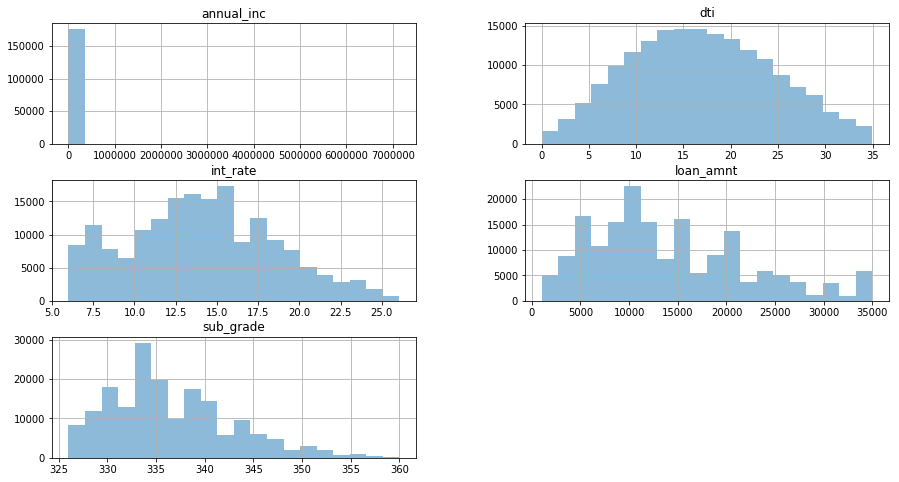

In [14]:
plt.figure()
df.loc[:,features].hist(alpha=0.5, bins=20, figsize=(15,8)); plt.legend(loc='best')

### Normalization
Below we apply some standard transformations to the features above in an attempt to make the distributions look more normal.The results are not perfect, but this is a real-world data set and so some difficulties are expected.

In [15]:
#Transform features to help with normalization.
df['log_int_rate'] = df.int_rate.apply(np.log)
df['log_annual_inc'] = df.annual_inc.apply(np.log)
df['trans_sub_grade'] = df.sub_grade.apply(lambda x: np.exp(x/100))
df['log_loan_amnt'] = df.loan_amnt.apply(np.log)

In [16]:
trans_features = ['log_int_rate', 'log_annual_inc', 'log_loan_amnt', 'trans_sub_grade', 'dti']

<Figure size 432x288 with 0 Axes>

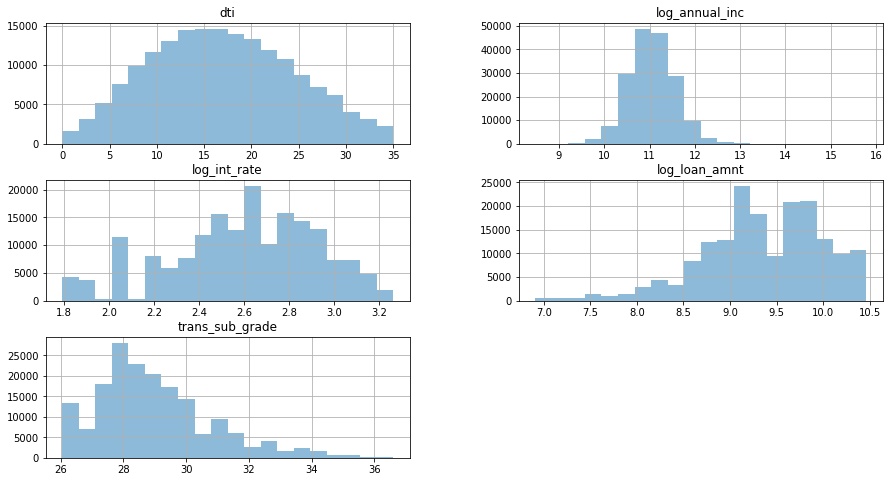

In [17]:
plt.figure()
df.loc[:,trans_features].hist(alpha=0.5, bins=20, figsize=(15,8)); plt.legend(loc='best')

### EDA Continued
Finally, we plot out joint distributions between each pair of features. The hope is that each of these will look roughly like 2-D normal distributions. In this case, again, there are exceptions, but at a coarse level, they are roughly normal. The exception is sub grade versus interest rate which are quite closely correlated. 

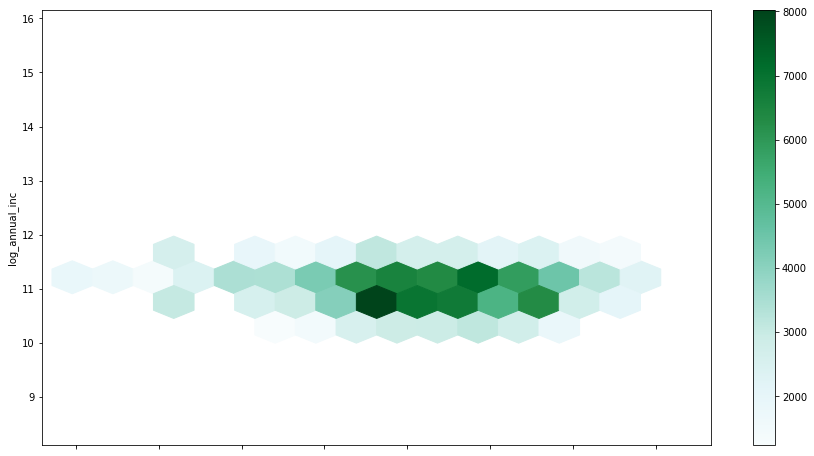

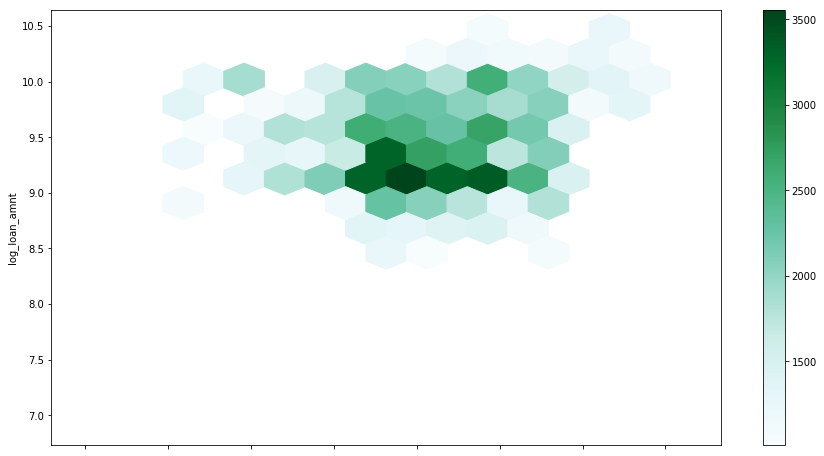

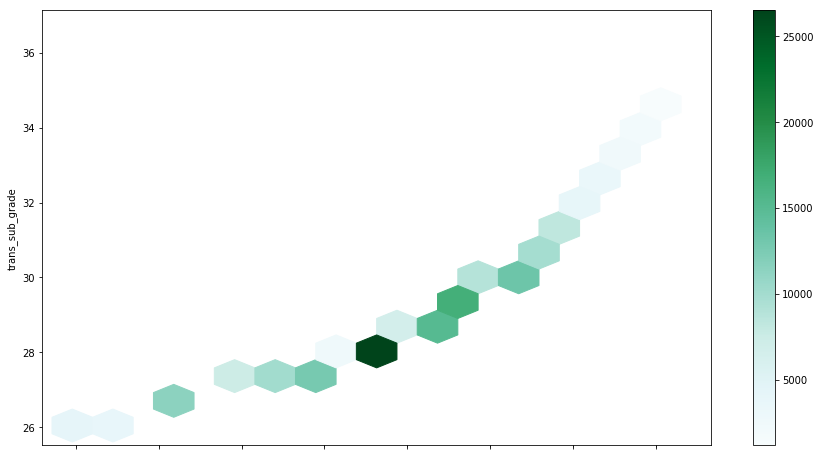

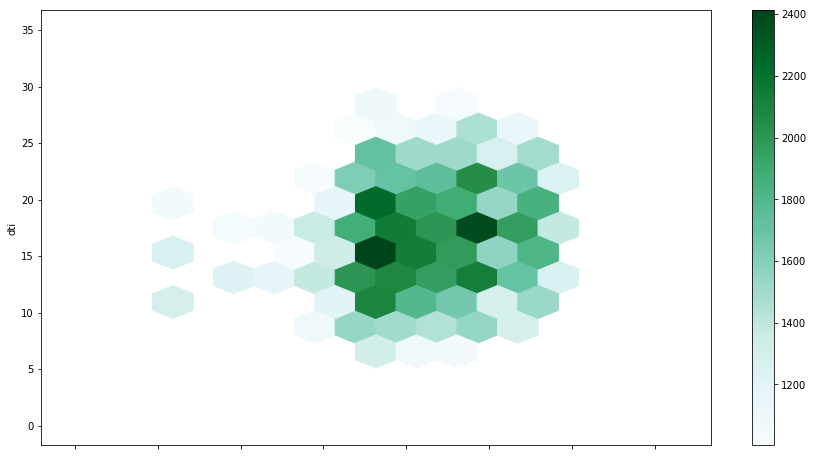

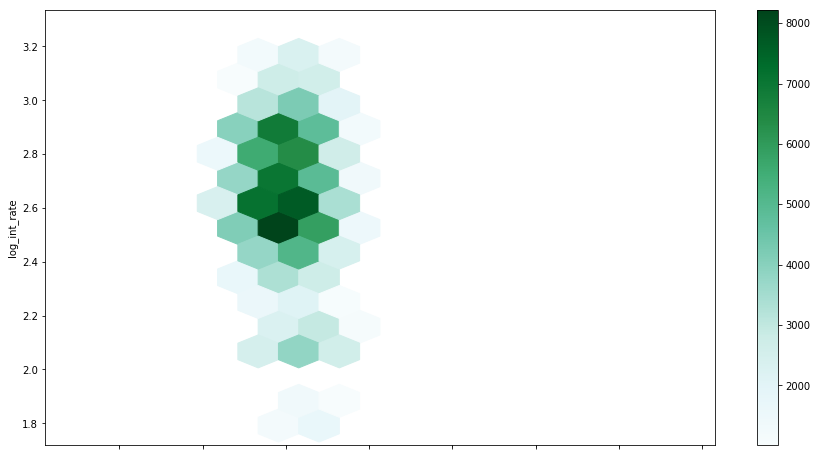

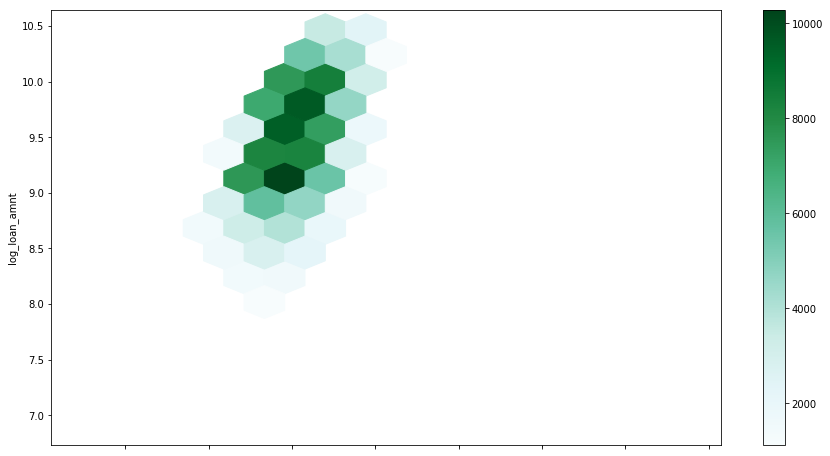

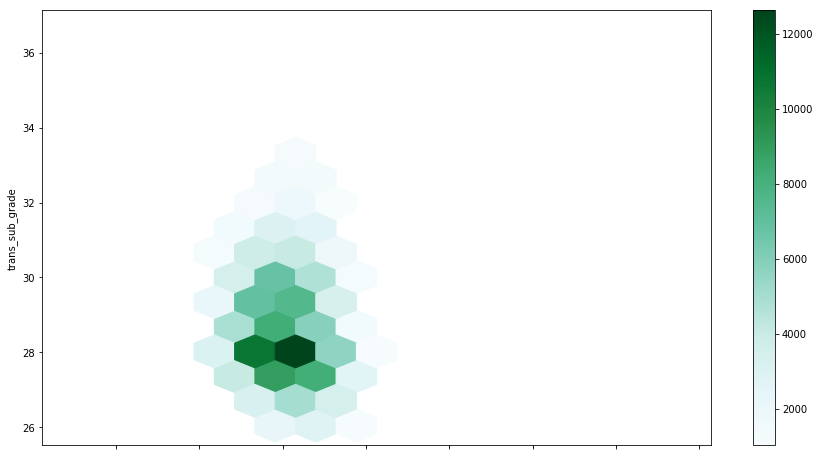

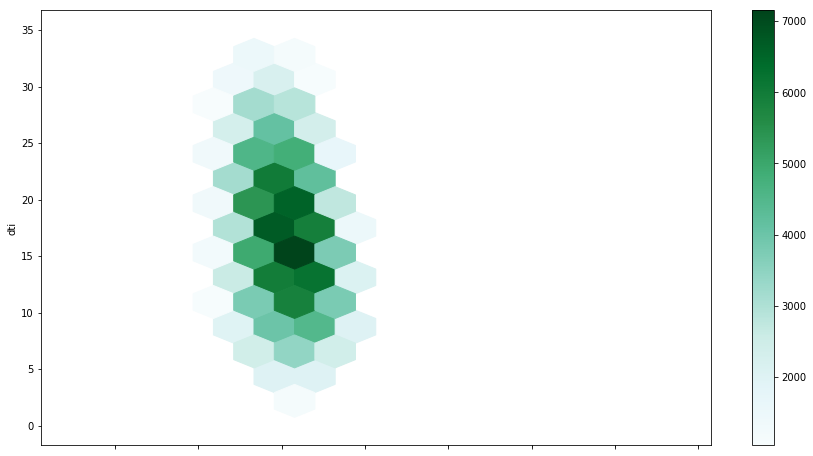

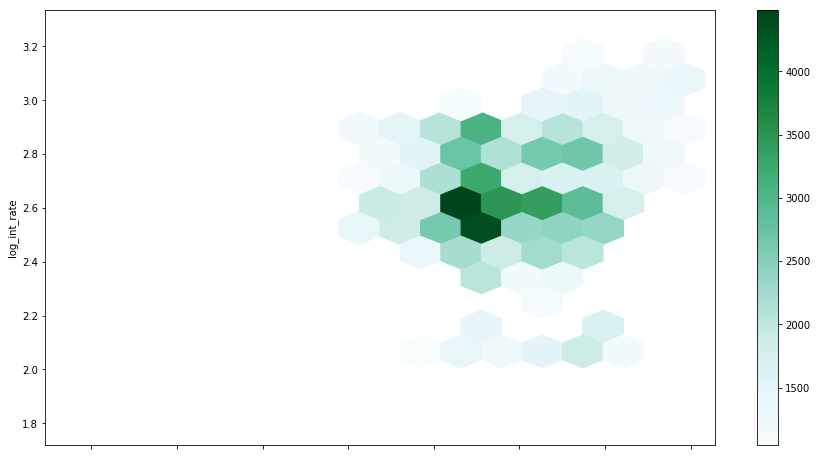

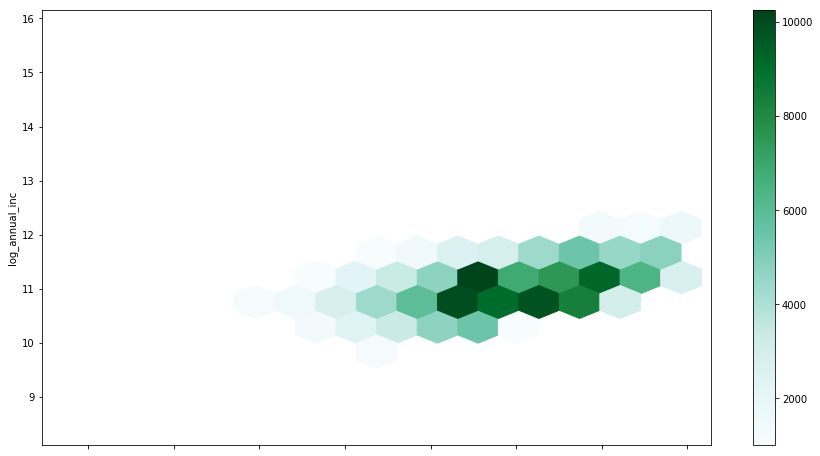

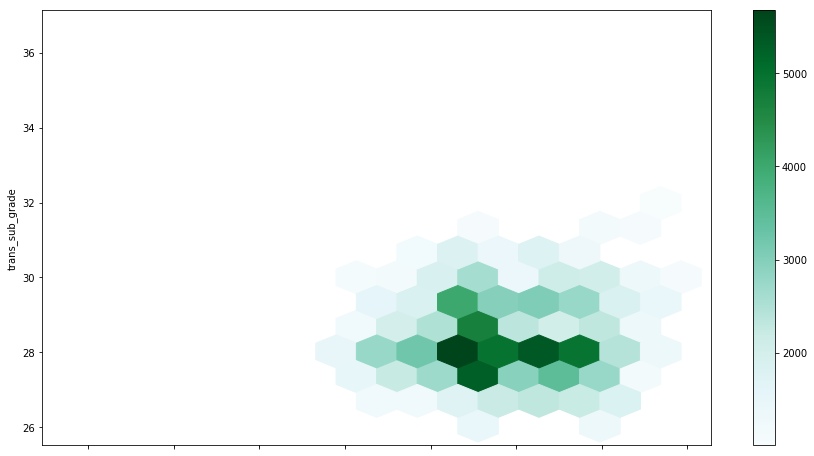

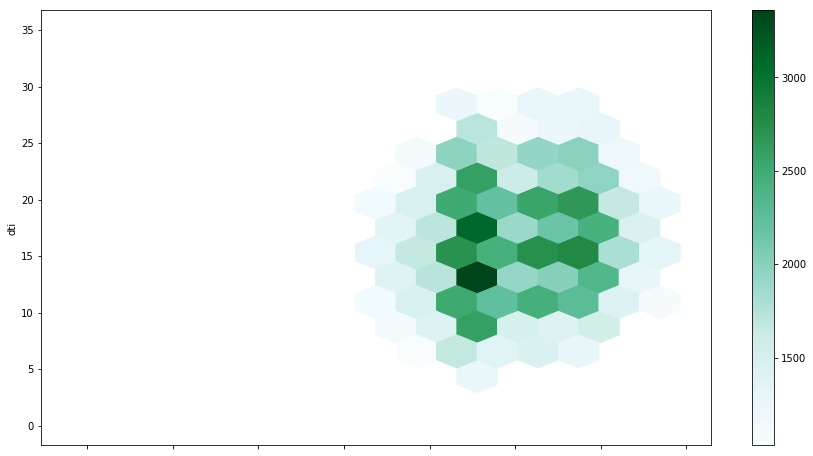

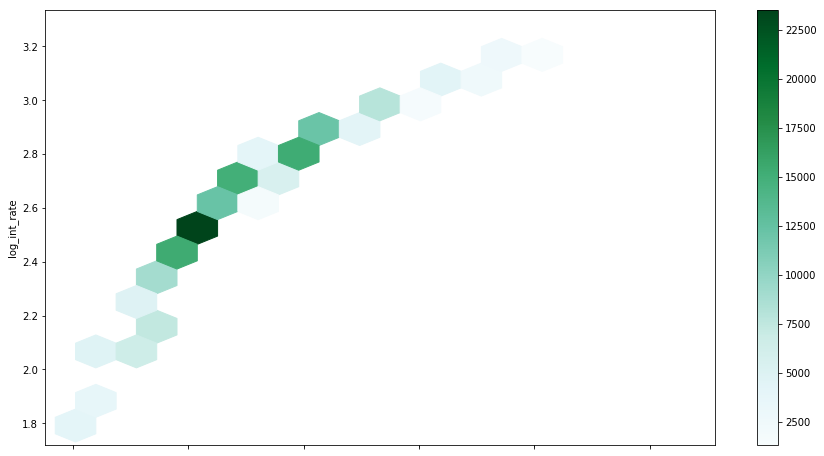

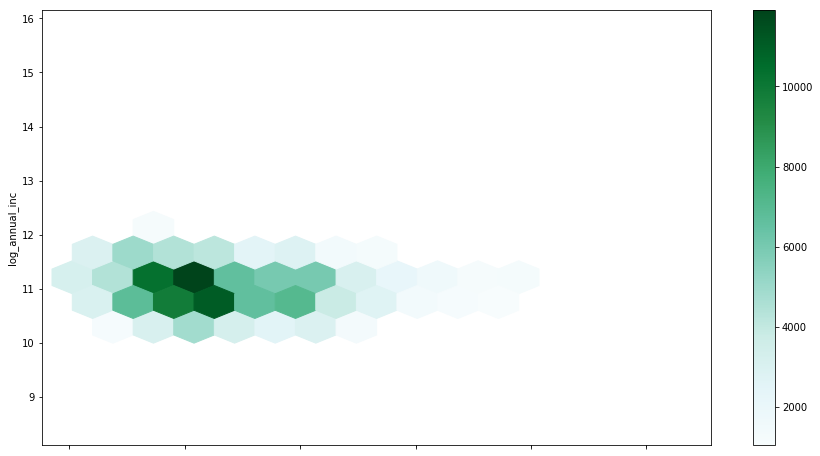

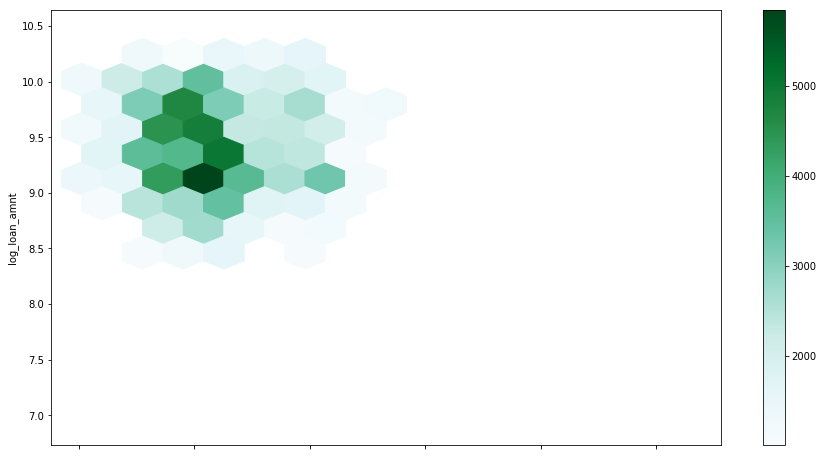

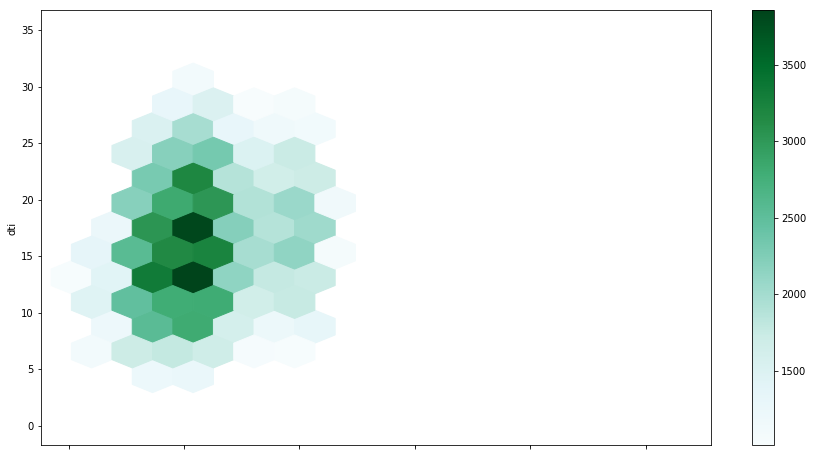

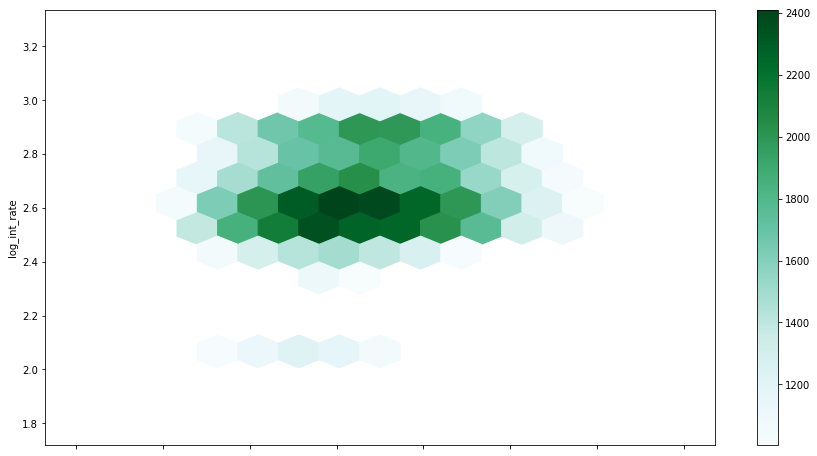

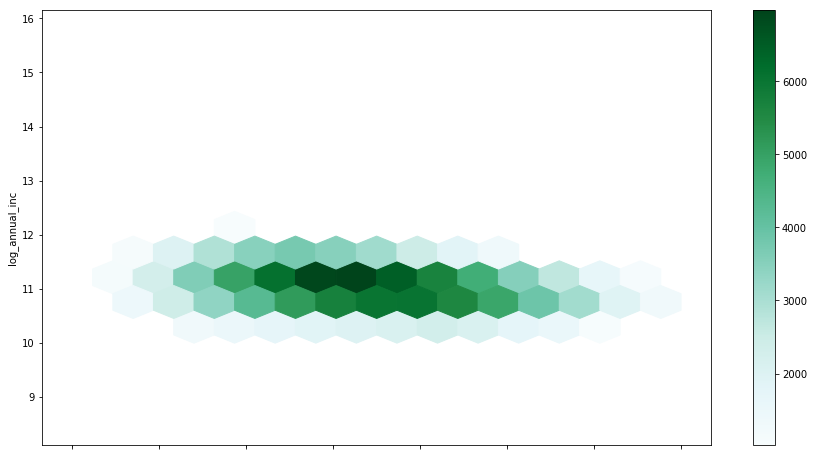

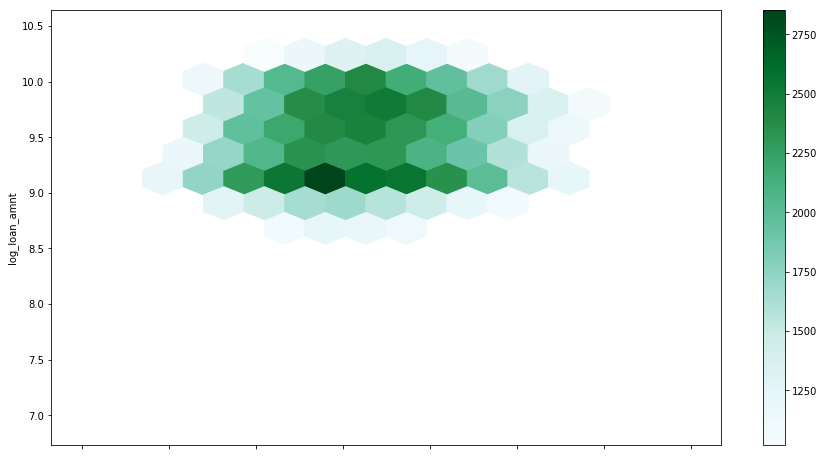

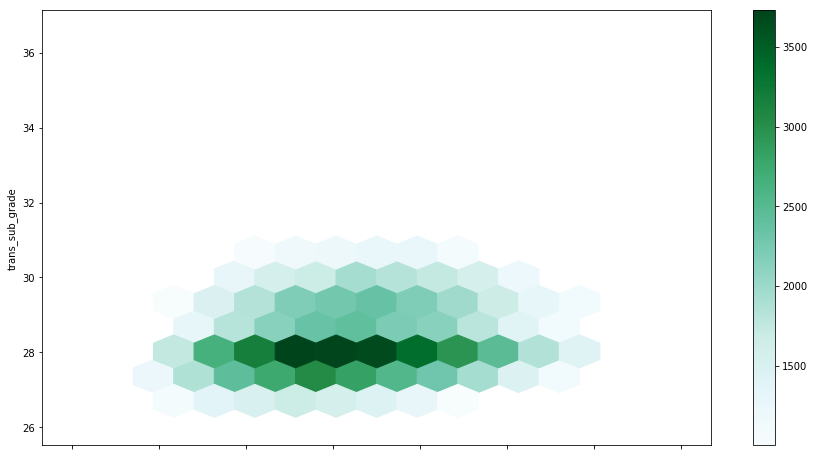

In [18]:
for pair in itertools.permutations(trans_features, 2):
    df.plot.hexbin(x = pair[0], y = pair[1], figsize=(15,8), gridsize=15, mincnt=1000)

### Class Imbalance and Correction
Another difficulty with this data set is that the classes we are trying to predict are unbalanced. We will use a downsampling method to handle this class unbalance.

In [19]:
df.loan_status.value_counts()/len(df)

1    0.83835
0    0.16165
Name: loan_status, dtype: float64

In [20]:
final = df.loc[:,trans_features+['loan_status']]

train, test = train_test_split(final, test_size = 0.2, random_state=SEED)

train_majority = train.loc[train.loan_status ==1]
train_minority = train.loc[train.loan_status == 0]

train_majority_down = resample(train_majority, replace=False, n_samples = len(train_minority),random_state=SEED)

train_down = pd.concat([train_majority_down, train_minority])

train_down.loan_status.value_counts()

1    22964
0    22964
Name: loan_status, dtype: int64

### Standard Normalization
Finally, we shall perform some standard normalization of the data in order to improve performance of the sampler.

In [21]:
means = train_down.loc[:, trans_features].mean()

standard_dev = train_down.loc[:, trans_features].std()

train_down.loc[:, trans_features] = (train_down.loc[:, trans_features] - means)/standard_dev

test.loc[:, trans_features] = (test.loc[:, trans_features] - means)/standard_dev

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### The Stan Model
Below is the model code written in the Stan programming language. There are several blocks of most Stan model: the data block where the input data is defined, the parameters block where model parameters are introduced, the model block where the model is specified, and the generated quantities block where samples which are dependent on the posterior distribution can be generated. There are a number of other blocks which are often used in Stan but not present in this model: transformed data and transformed parameters are quite common as well.

There is a significant modification that must happen with the data matrix. If we hand the normalized data matrix to the sampler as-is, the sampling might take a long time. Instead, we take a QR decompostion of the data matrix and input this to the sampler. At a high level, what is happening is that the sampler is looking through space for a particular set. It is more efficient to find this set by stepping in perpendicular directions rather than in the arbitrary directions as defined by the data matrix. Thus, we find an orthonormal basis of the column space of the data matrix and give this as input (this is the Q matrix in the QR decomposition). The R matrix serves as a map between the "natural" basis given by the data matrix and the orthonormal basis given by the Q matrix.

We could have input the data matrix directly and added a transformed data block to the Stan model and used Stan's QR decomposition. However, owing to memory efficiency concerns, we have found it necessary to use numpy's QR decomposition outside of Stan and simply give the Stan model the QR matrix directly.

In [22]:
stan_model = '''
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] Q;
  matrix[K,K] R;
  matrix[K,K] R_inverse;
  int y[N];
}
parameters {
    real alpha;           // intercept
    vector[K] theta;      // coefficients on Q_ast
} 
model {
    y ~ bernoulli_logit(Q * theta + alpha);  // likelihood
}
generated quantities {
      vector[K] beta;
      beta = R_inverse * theta; // coefficients on x
}'''

### Compiling the Stan model
Stan is a domain-specific language written in C++. The model must be compiled into a C++ program. The upshot of this is that a model can be compiled once and reused as long as the data schema does not change.

In [23]:
sm = stan.StanModel(model_code=stan_model, model_name='LR')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL LR_8f7046ff5d4a7dfea44581b4821f6599 NOW.


In [24]:
#Here we compute the QR decomposition as well as the inverse of the R matrix which provides a map from Q-space
#to the natural basis. 
q, r = np.linalg.qr(train_down.loc[:, trans_features], mode='reduced')

q = q*np.sqrt(len(train_down))
r = r/np.sqrt(len(train_down))

r_inverse = np.linalg.inv(r)

In [25]:
#The sampling methods in PyStan require the data to be input as a Python dictionary whose keys match
#the data block of the Stan code.
data = dict(Q = q, 
            R = r, 
            R_inverse = r_inverse, 
            N = len(train_down), 
            K = train_down.shape[1]-1, 
            y = train_down.loan_status.values)



In [26]:
#We perform the sampling. On the AWS instance we're using, this takes just about three minutes.
fit = sm.sampling(data=data, chains=4, iter=3000, warmup=1000)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
#Here are some basic statistics about the samples drawn from the posterior. Pay attention
#in particular to the Rhat value. If the Rhat values deviate too far from 1.0, the sampler
#did not converge well. 
print(fit)

Inference for Stan model: LR_8f7046ff5d4a7dfea44581b4821f6599.
4 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    5.6e-3  1.1e-4   0.01  -0.01-1.3e-3 5.5e-3   0.01   0.02   8000    1.0
theta[0]  -0.67  1.2e-4   0.01  -0.69  -0.68  -0.67  -0.66  -0.65   8000    1.0
theta[1]  -0.18  1.1e-4   0.01   -0.2  -0.19  -0.18  -0.17  -0.16   8000    1.0
theta[2]  -0.23  1.1e-4   0.01  -0.24  -0.23  -0.23  -0.22  -0.21   8000    1.0
theta[3]  -0.08  1.2e-4   0.01   -0.1  -0.08  -0.08  -0.07  -0.06   8000    1.0
theta[4]   0.09  1.1e-4 9.7e-3   0.07   0.08   0.09   0.09   0.11   8000    1.0
beta[0]   -0.41  3.4e-4   0.03  -0.47  -0.43  -0.41  -0.39  -0.35   8000    1.0
beta[1]    0.29  1.4e-4   0.01   0.26   0.28   0.29    0.3   0.31   8000    1.0
beta[2]   -0.24  1.3e-4   0.01  -0.26  -0.24  -0.24  -0.23  -0.21   8000    1.0
beta[3]   -0.22  3.

### Assessment of Convergence
We use the Arviz library to give a brief assessment of convergence of the MCMC method. In the energy plot, the BFMI statistic larger than roughly 0.3 indicates good convergence. See Section 6.1 of [the survey](https://arxiv.org/pdf/1701.02434.pdf) for a more thorough discussion. We seem to be in good shape.

In [28]:
inf_data = az.convert_to_inference_data(fit)

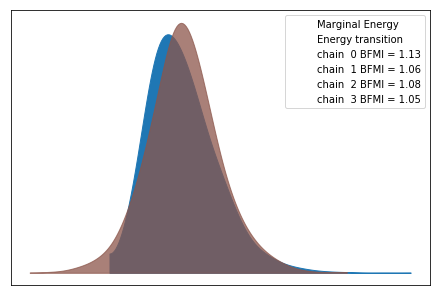

In [29]:
az.plot_energy(inf_data)

### The Posteriors
Below are plots of the posterior distributions for each feature. Recall that the $beta$s are the coefficients in our logistic regression of our raw features and that these plots are one-dimensional marginals of distributions which are inherently multi-dimensional.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc679deeb8>,
      dtype=object)

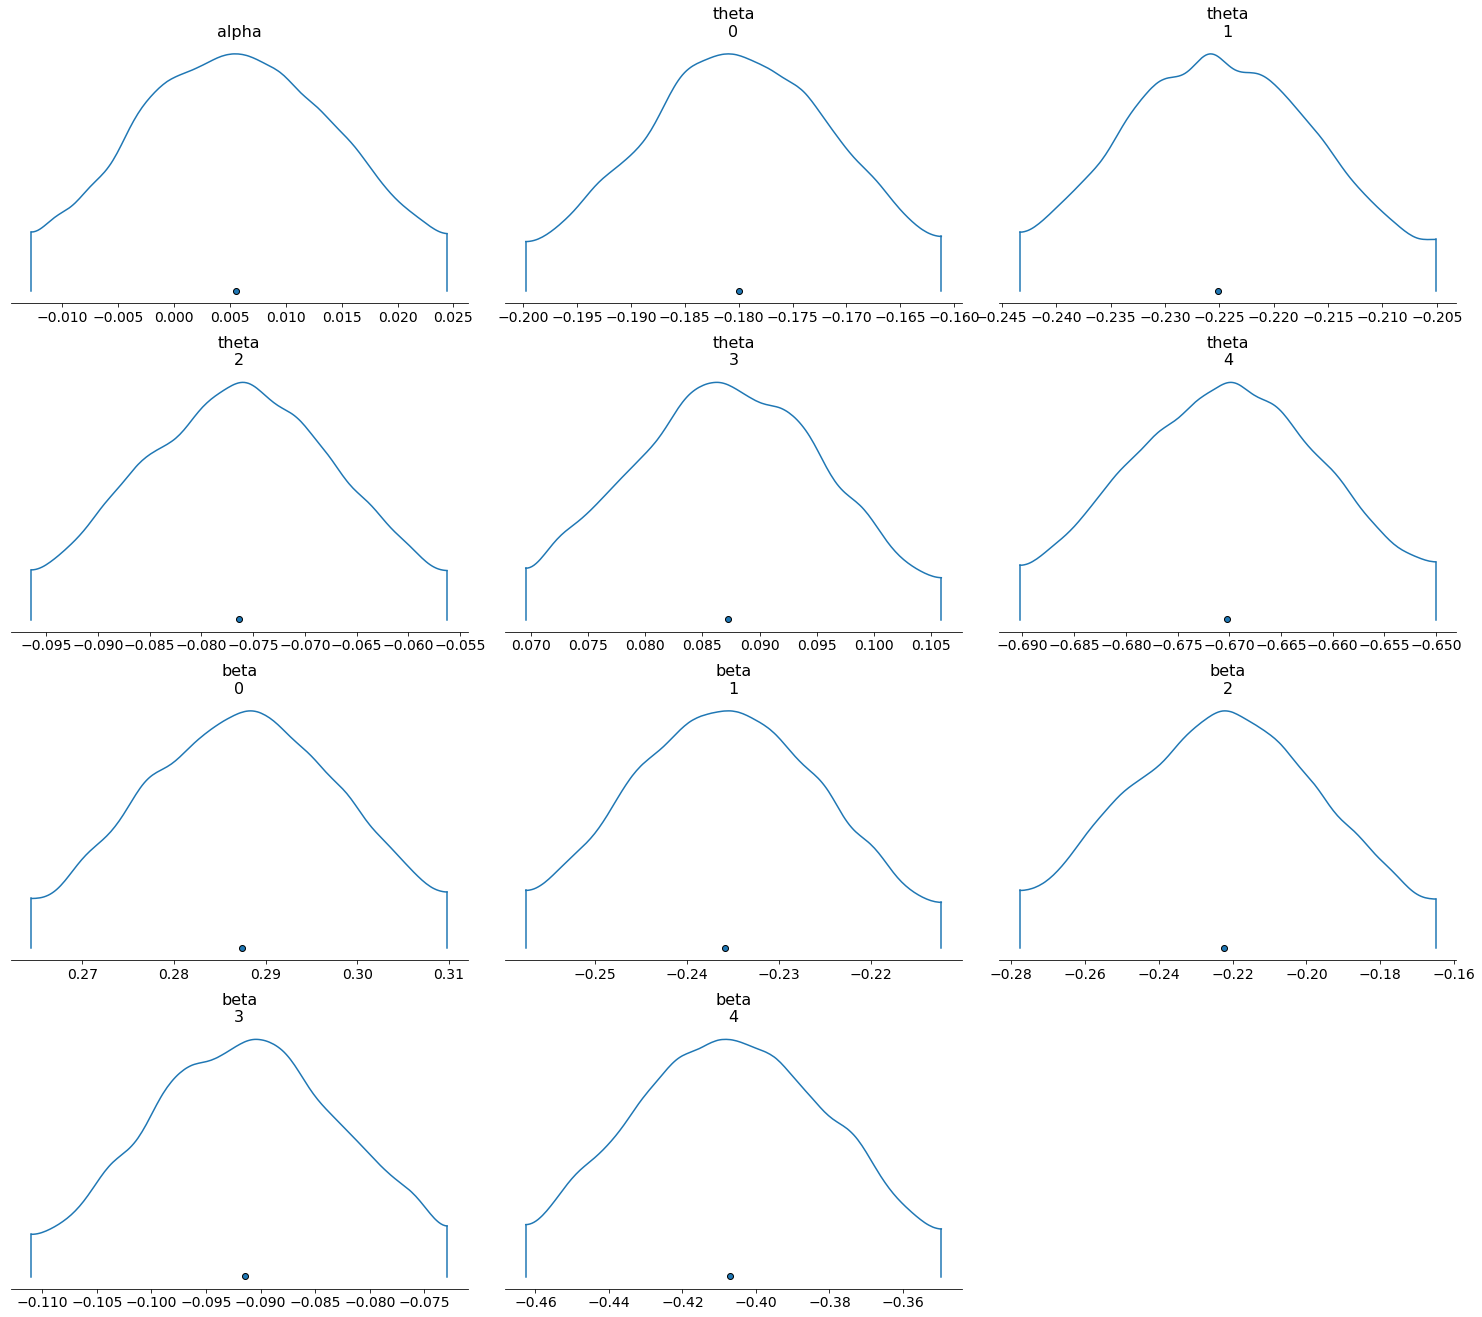

In [30]:
az.plot_density(inf_data)

### Prediction
Prediction using this method takes a format which may seem peculiar at first, but what is really happening is a kind of approximate Monte Carlo integration over the posterior distribution. This can be elegantly and easily done inside of Stan's generated quantities block, but we have chosen to utilize numpy, again, for memory efficiency purposes. 

In [31]:
#Extracts the samples from the fit object.
samples = fit.extract()

In [32]:
beta = samples['beta']

In [33]:
#This is takes a dot product between the features and the coefficients
outcomes = np.dot(beta, np.transpose(test.iloc[:,:5].values))

In [35]:
#Add the alpha offset, apply the expit function (which is inverse to logit), and then assign 
#a Bernoulli r.v. whose probability p is the output of the expit.
for j in range(outcomes.shape[1]):
    outcomes[:,j] = scipy.special.expit(outcomes[:,j] + samples['alpha'])
    outcomes[:,j] = bernoulli.rvs(p=outcomes[:,j], size=8000, random_state=SEED)
    

In [36]:
#This is simply an assessment of how often the Bernoulli rv turns up 0 or 1 corresponding
#to a Charged Off outcome or Fully Paid outcome respectively.
outcomes = np.sum(outcomes, axis=0)
outcomes

array([5387., 4160., 5419., ..., 5270., 4948., 4361.])

In [37]:
#Since there are 8000 samples, if fewer than 4000 turn up 1, we shall predict that the loan will be Charged Off
#and if more than 4000 turn up 1, we shall predict the outcome is Fully Paid.
outcomes = np.floor(outcomes/4000.)

In [38]:
#Outcomes contains the predicted loan outcome whereas test.loan_status.values contains the actual 
#outcome of the loan. We shall assess how our logistic regression has performed.
unique, counts = np.unique(outcomes - test.loan_status.values, return_counts=True)

In [41]:
#A -1 corresponds to a false positive (predicted default but the loan was actually paid) whereas a 1 
#corresponds to a false negative (predicted to be paid but the loan actually defaulted).
prediction_counts = dict(zip(unique, counts))
prediction_counts

{-1.0: 11013, 0.0: 22458, 1.0: 1968}

In [40]:
#Actual outcomes
test.loan_status.value_counts()

1    29760
0     5679
Name: loan_status, dtype: int64

In [43]:
#Percentage of defaults correctly identified
(test.loan_status.value_counts()[0] - prediction_counts[1.0])/test.loan_status.value_counts()[0]

0.653460116217644

In [45]:
#Percentage of paid loans correctly identified
(test.loan_status.value_counts()[1] - prediction_counts[-1.0])/test.loan_status.value_counts()[1]

0.6299395161290322

### Concluding Remarks
We could have fit a similar model using any logistic regression implementation, but with a Bayesian model, we are able to give some confidence score to our prediction in addition to its outcome. In following articles, we shall display a number of powerful extensions to this model which are most readily available only in a Bayesian framework and are naturally implemented using Hamiltonian MC and NUTS. In particular, we shall display hierarchical modeling as well as show how to handle missingness in a Bayesian framework and how to handle ordinal features. We shall also explore various model selection techniques only available in the Bayesian modeling world. 